In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomPendulum-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-06 08:50:48.429806


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 32
base load ckpt ckpt_basevi_pendulum_unweighted
base load self.initial_belief.data.sum() tensor(-7.4551)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-1.3103)
penalty_target_min tensor(-6.1010) penalty_target_max tensor(11.1658)
train_loss:  -3.8585697795867917
valid_loss:  -4.71965581665039
h_min_tilde -6.1009912 ell_tilde -4.030786986999511 kappa_tilde 0.0006950137566499112


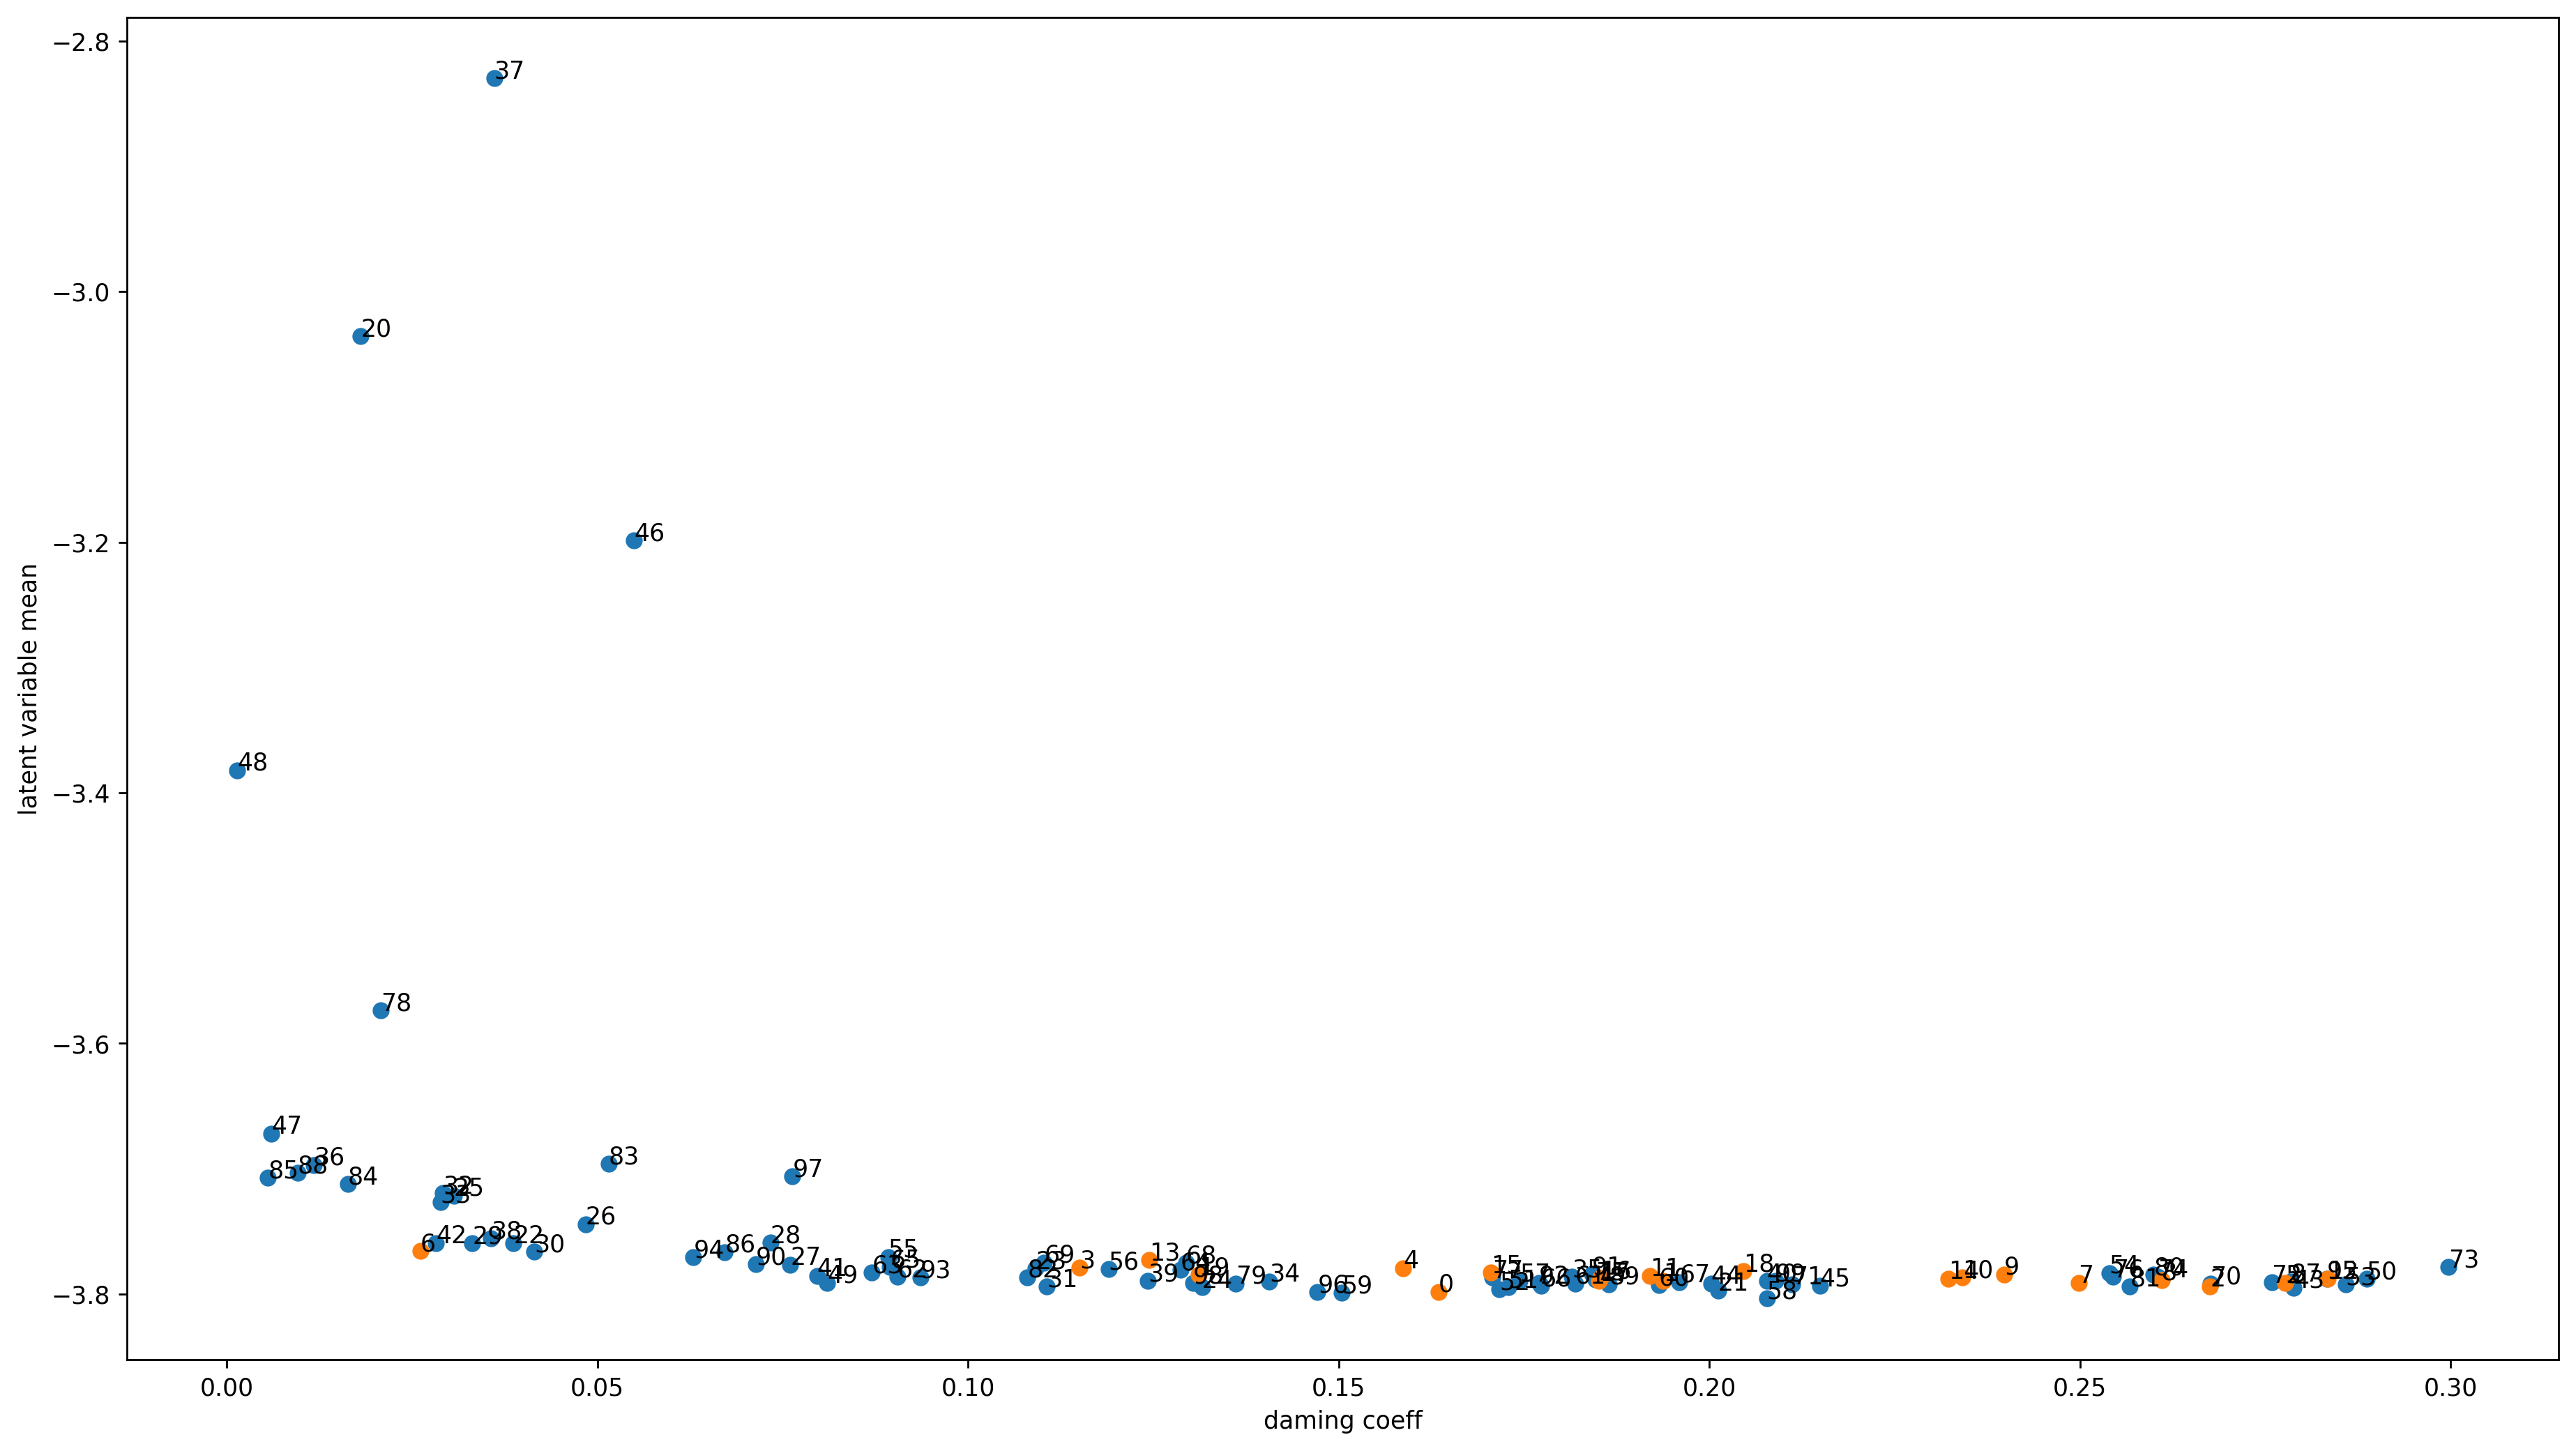

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.66120719909668

 2 3.9288480281829834

 3 3.6632320880889893

 4 3.6389732360839844

 5 3.6402268409729004

 6 3.6680908203125

 7 3.5745649337768555

 8 3.4899749755859375

 9 3.422928810119629

 10 3.4316959381103516

 11 3.4286131858825684

 12 3.413222551345825

 13 3.401677370071411

 14 3.4606621265411377

 15 3.4154136180877686

 16 3.599545955657959

 17 3.644282341003418

 18 3.4364452362060547

 19 3.4741413593292236

 20 3.5599632263183594

 21 3.4771318435668945

 22 3.5206613540649414

 23 3.391768217086792

 24 3.452741861343384

 25 3.397724151611328

 26 3.4423391819000244

 27 3.435830593109131

 28 3.5096662044525146

 29 3.4142675399780273

 30 3.5463201999664307

 31 3.393747091293335

 32 3.510512351989746

 33 3.434781074523926

 34 3.6153054237365723

 35 3.4460604190826416

 36 3.513903856277466

 37 3.441251039505005

 38 3.3976738452911377

 39 3.548762083053589

 40 3.5003771781921387

 41 3.3188958168029785

 42 3.382864236831665

 43 3.367728471755981

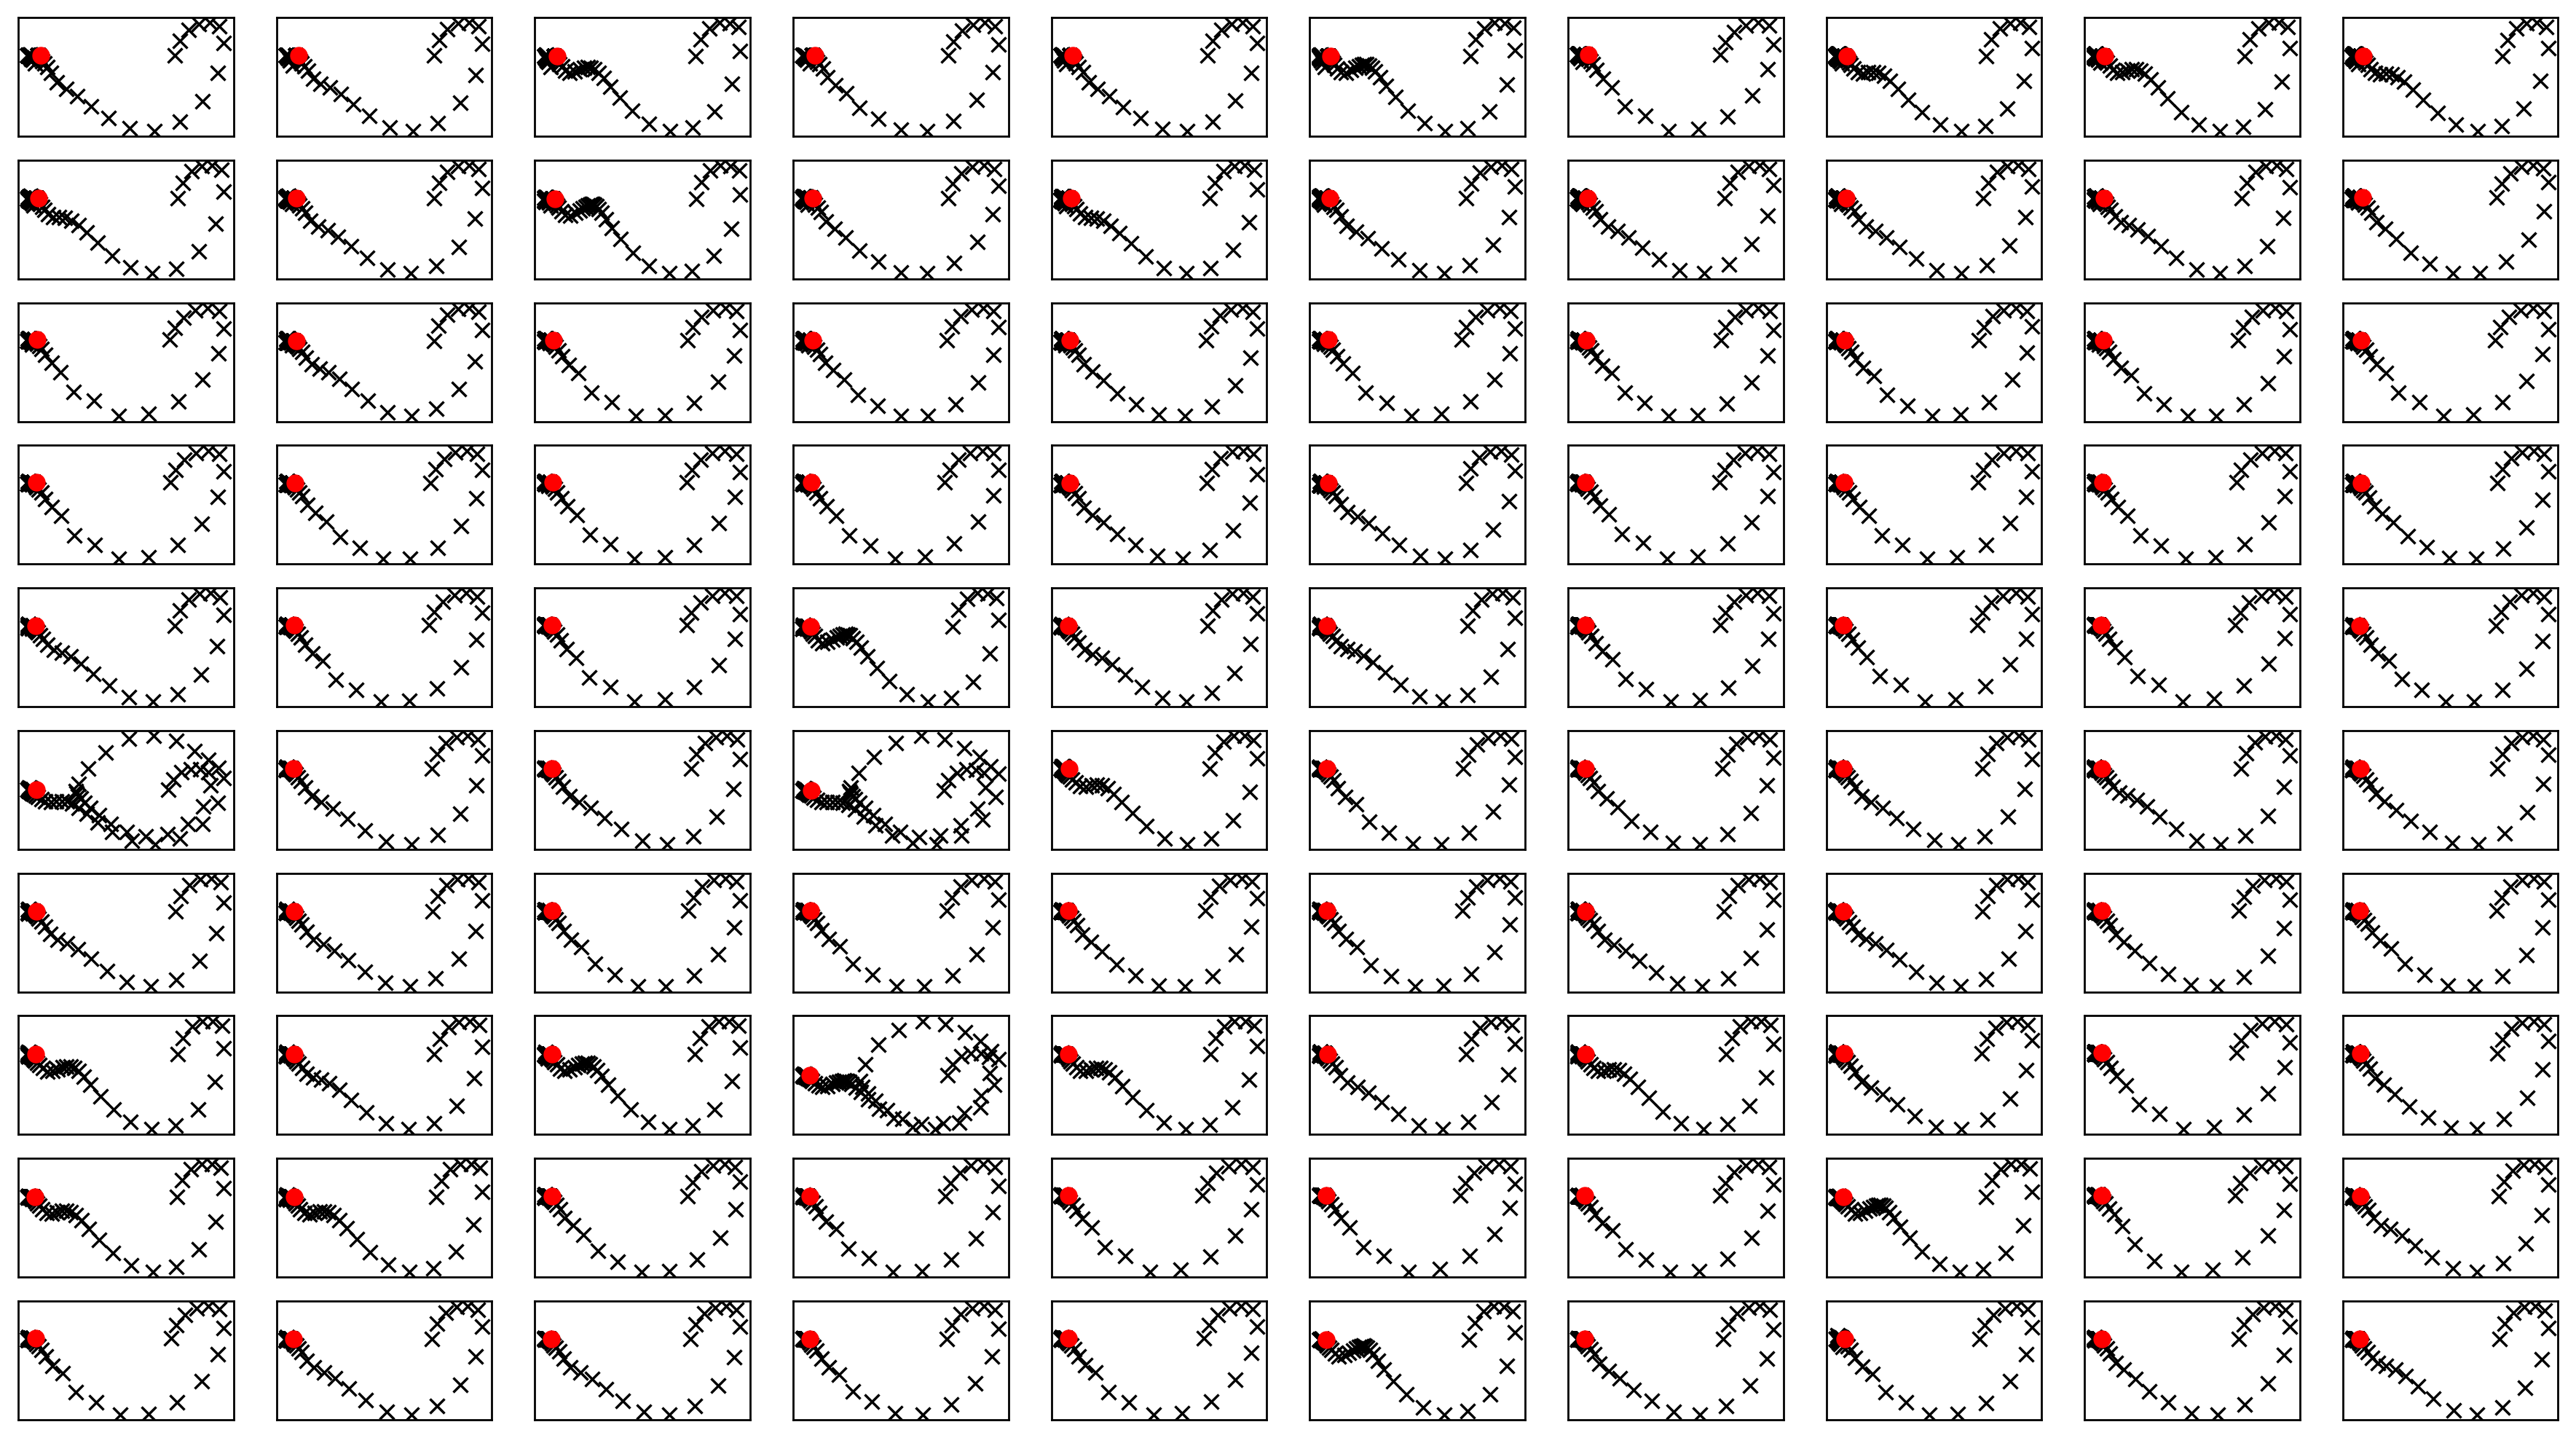

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)

実環境方策rollout vs Sim環境方策rollout


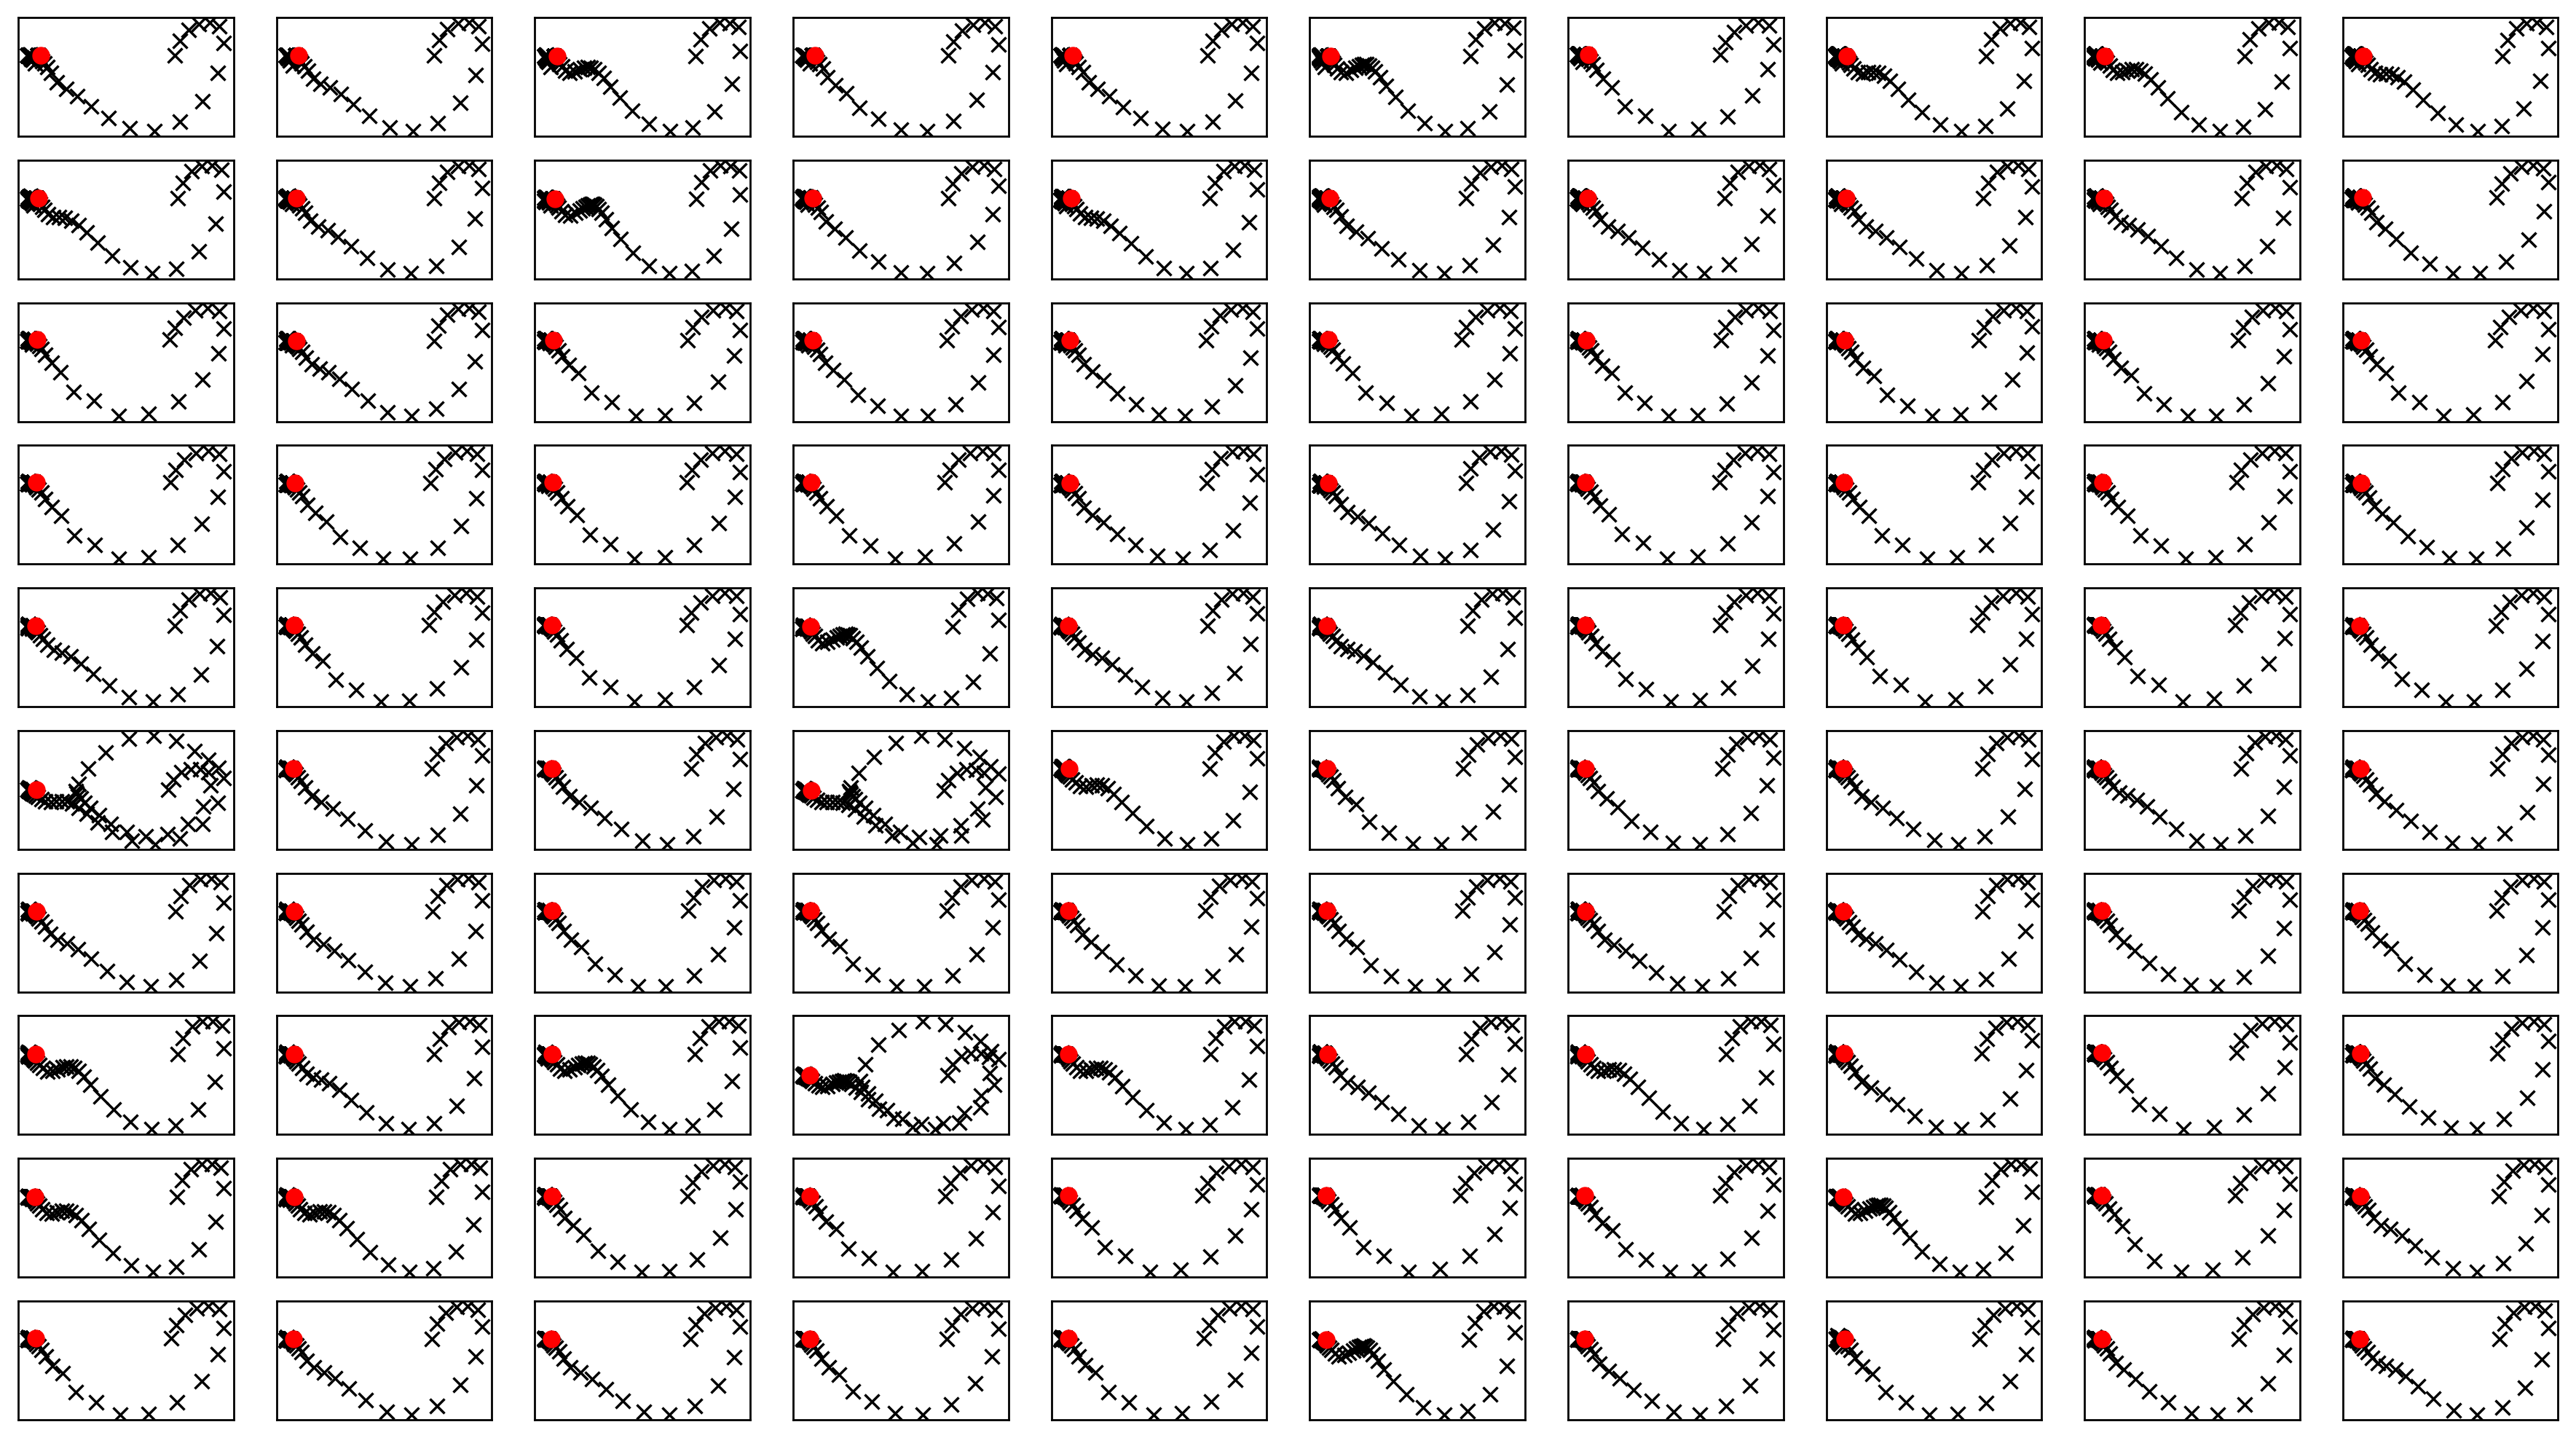

In [9]:


fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
#     ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
#     ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1])
    
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro") 

plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-06-06 11:02:15.778251


# Iter 1

In [11]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [12]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.16666  validloss 1.42210±0.00000  bestvalidloss 1.42210  last_update 0
train: iter 1  trainloss 0.78808  validloss 0.85063±0.00000  bestvalidloss 0.85063  last_update 0
train: iter 2  trainloss 0.70299  validloss 0.66601±0.00000  bestvalidloss 0.66601  last_update 0
train: iter 3  trainloss 0.65604  validloss 0.60159±0.00000  bestvalidloss 0.60159  last_update 0
train: iter 4  trainloss 0.61824  validloss 0.55202±0.00000  bestvalidloss 0.55202  last_update 0
train: iter 5  trainloss 0.58570  validloss 0.51829±0.00000  bestvalidloss 0.51829  last_update 0
train: iter 6  trainloss 0.55455  validloss 0.49015±0.00000  bestvalidloss 0.49015  last_update 0
train: iter 7  trainloss 0.52444  validloss 0.45441±0.00000  bestvalidloss 0.45441  last_update 0
train: iter 8  trainloss 0.49305  validloss 0.42946±0.00000  bestvalidloss 0.42946  last_update 0
train: iter 9  trainloss 0.47167  validloss 0.42212±0.00000  bestvalidloss 0.42212  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.27627  validloss 0.22525±0.00000  bestvalidloss 0.22472  last_update 8
train: iter 85  trainloss 0.27469  validloss 0.24819±0.00000  bestvalidloss 0.22472  last_update 9
train: iter 86  trainloss 0.27133  validloss 0.23472±0.00000  bestvalidloss 0.22472  last_update 10
train: iter 87  trainloss 0.27138  validloss 0.22730±0.00000  bestvalidloss 0.22472  last_update 11
train: iter 88  trainloss 0.27317  validloss 0.22418±0.00000  bestvalidloss 0.22418  last_update 0
train: iter 89  trainloss 0.26853  validloss 0.22427±0.00000  bestvalidloss 0.22418  last_update 1
train: iter 90  trainloss 0.27331  validloss 0.22944±0.00000  bestvalidloss 0.22418  last_update 2
train: iter 91  trainloss 0.27027  validloss 0.21876±0.00000  bestvalidloss 0.21876  last_update 0
train: iter 92  trainloss 0.27353  validloss 0.21873±0.00000  bestvalidloss 0.21873  last_update 0
train: iter 93  trainloss 0.27047  validloss 0.22199±0.00000  bestvalidloss 0.21873  last_update 1
train: i

train: iter 167  trainloss 0.25315  validloss 0.20869±0.00000  bestvalidloss 0.20597  last_update 6
train: iter 168  trainloss 0.25280  validloss 0.20735±0.00000  bestvalidloss 0.20597  last_update 7
train: iter 169  trainloss 0.24867  validloss 0.21691±0.00000  bestvalidloss 0.20597  last_update 8
train: iter 170  trainloss 0.25164  validloss 0.20852±0.00000  bestvalidloss 0.20597  last_update 9
train: iter 171  trainloss 0.25147  validloss 0.20844±0.00000  bestvalidloss 0.20597  last_update 10
train: iter 172  trainloss 0.25420  validloss 0.20641±0.00000  bestvalidloss 0.20597  last_update 11
train: iter 173  trainloss 0.25056  validloss 0.20471±0.00000  bestvalidloss 0.20471  last_update 0
train: iter 174  trainloss 0.25094  validloss 0.24112±0.00000  bestvalidloss 0.20471  last_update 1
train: iter 175  trainloss 0.24843  validloss 0.22656±0.00000  bestvalidloss 0.20471  last_update 2
train: iter 176  trainloss 0.24980  validloss 0.21093±0.00000  bestvalidloss 0.20471  last_update 

train: iter 249  trainloss 0.24020  validloss 0.20559±0.00000  bestvalidloss 0.20154  last_update 12
train: iter 250  trainloss 0.24596  validloss 0.20822±0.00000  bestvalidloss 0.20154  last_update 13
train: iter 251  trainloss 0.23838  validloss 0.20178±0.00000  bestvalidloss 0.20154  last_update 14
train: iter 252  trainloss 0.23868  validloss 0.21088±0.00000  bestvalidloss 0.20154  last_update 15
train: iter 253  trainloss 0.24061  validloss 0.22139±0.00000  bestvalidloss 0.20154  last_update 16
train: iter 254  trainloss 0.24072  validloss 0.20834±0.00000  bestvalidloss 0.20154  last_update 17
train: iter 255  trainloss 0.24328  validloss 0.20512±0.00000  bestvalidloss 0.20154  last_update 18
train: iter 256  trainloss 0.24447  validloss 0.20331±0.00000  bestvalidloss 0.20154  last_update 19
train: iter 257  trainloss 0.24050  validloss 0.20154±0.00000  bestvalidloss 0.20154  last_update 20
train: iter 258  trainloss 0.24109  validloss 0.22172±0.00000  bestvalidloss 0.20154  last_

train: iter 332  trainloss 0.23780  validloss 0.19602±0.00000  bestvalidloss 0.19532  last_update 3
train: iter 333  trainloss 0.23543  validloss 0.20165±0.00000  bestvalidloss 0.19532  last_update 4
train: iter 334  trainloss 0.23814  validloss 0.19736±0.00000  bestvalidloss 0.19532  last_update 5
train: iter 335  trainloss 0.24105  validloss 0.20785±0.00000  bestvalidloss 0.19532  last_update 6
train: iter 336  trainloss 0.23317  validloss 0.19768±0.00000  bestvalidloss 0.19532  last_update 7
train: iter 337  trainloss 0.24042  validloss 0.19873±0.00000  bestvalidloss 0.19532  last_update 8
train: iter 338  trainloss 0.23509  validloss 0.19702±0.00000  bestvalidloss 0.19532  last_update 9
train: iter 339  trainloss 0.23456  validloss 0.20380±0.00000  bestvalidloss 0.19532  last_update 10
train: iter 340  trainloss 0.23342  validloss 0.19598±0.00000  bestvalidloss 0.19532  last_update 11
train: iter 341  trainloss 0.23482  validloss 0.20125±0.00000  bestvalidloss 0.19532  last_update 

train: iter 415  trainloss 0.23284  validloss 0.19260±0.00000  bestvalidloss 0.19260  last_update 0
train: iter 416  trainloss 0.23201  validloss 0.20465±0.00000  bestvalidloss 0.19260  last_update 1
train: iter 417  trainloss 0.23165  validloss 0.20098±0.00000  bestvalidloss 0.19260  last_update 2
train: iter 418  trainloss 0.23335  validloss 0.22896±0.00000  bestvalidloss 0.19260  last_update 3
train: iter 419  trainloss 0.23291  validloss 0.20242±0.00000  bestvalidloss 0.19260  last_update 4
train: iter 420  trainloss 0.23033  validloss 0.19601±0.00000  bestvalidloss 0.19260  last_update 5
train: iter 421  trainloss 0.23070  validloss 0.20621±0.00000  bestvalidloss 0.19260  last_update 6
train: iter 422  trainloss 0.23345  validloss 0.19470±0.00000  bestvalidloss 0.19260  last_update 7
train: iter 423  trainloss 0.23227  validloss 0.21601±0.00000  bestvalidloss 0.19260  last_update 8
train: iter 424  trainloss 0.23159  validloss 0.21492±0.00000  bestvalidloss 0.19260  last_update 9


train: iter 497  trainloss 0.22838  validloss 0.19247±0.00000  bestvalidloss 0.18964  last_update 21
train: iter 498  trainloss 0.22781  validloss 0.20618±0.00000  bestvalidloss 0.18964  last_update 22
train: iter 499  trainloss 0.22964  validloss 0.23166±0.00000  bestvalidloss 0.18964  last_update 23
train: iter 500  trainloss 0.22821  validloss 0.19625±0.00000  bestvalidloss 0.18964  last_update 24
train: iter 501  trainloss 0.23360  validloss 0.19988±0.00000  bestvalidloss 0.18964  last_update 25
train: iter 502  trainloss 0.22931  validloss 0.19218±0.00000  bestvalidloss 0.18964  last_update 26
train: iter 503  trainloss 0.22907  validloss 0.20957±0.00000  bestvalidloss 0.18964  last_update 27
train: iter 504  trainloss 0.22983  validloss 0.20183±0.00000  bestvalidloss 0.18964  last_update 28
train: iter 505  trainloss 0.22923  validloss 0.19737±0.00000  bestvalidloss 0.18964  last_update 29
train: iter 506  trainloss 0.22825  validloss 0.20357±0.00000  bestvalidloss 0.18964  last_

train: iter 580  trainloss 0.22847  validloss 0.19279±0.00000  bestvalidloss 0.18918  last_update 23
train: iter 581  trainloss 0.22654  validloss 0.21009±0.00000  bestvalidloss 0.18918  last_update 24
train: iter 582  trainloss 0.22852  validloss 0.20223±0.00000  bestvalidloss 0.18918  last_update 25
train: iter 583  trainloss 0.22761  validloss 0.19892±0.00000  bestvalidloss 0.18918  last_update 26
train: iter 584  trainloss 0.22757  validloss 0.19271±0.00000  bestvalidloss 0.18918  last_update 27
train: iter 585  trainloss 0.22674  validloss 0.19085±0.00000  bestvalidloss 0.18918  last_update 28
train: iter 586  trainloss 0.22722  validloss 0.22303±0.00000  bestvalidloss 0.18918  last_update 29
train: iter 587  trainloss 0.22846  validloss 0.18871±0.00000  bestvalidloss 0.18871  last_update 0
train: iter 588  trainloss 0.22666  validloss 0.20071±0.00000  bestvalidloss 0.18871  last_update 1
train: iter 589  trainloss 0.22657  validloss 0.18976±0.00000  bestvalidloss 0.18871  last_up

train: iter 662  trainloss 0.22574  validloss 0.20418±0.00000  bestvalidloss 0.18714  last_update 34
train: iter 663  trainloss 0.22452  validloss 0.19437±0.00000  bestvalidloss 0.18714  last_update 35
train: iter 664  trainloss 0.22610  validloss 0.19100±0.00000  bestvalidloss 0.18714  last_update 36
train: iter 665  trainloss 0.22678  validloss 0.19123±0.00000  bestvalidloss 0.18714  last_update 37
train: iter 666  trainloss 0.22696  validloss 0.19221±0.00000  bestvalidloss 0.18714  last_update 38
train: iter 667  trainloss 0.22392  validloss 0.20940±0.00000  bestvalidloss 0.18714  last_update 39
train: iter 668  trainloss 0.22326  validloss 0.19293±0.00000  bestvalidloss 0.18714  last_update 40
train: iter 669  trainloss 0.22421  validloss 0.21758±0.00000  bestvalidloss 0.18714  last_update 41
train: iter 670  trainloss 0.22621  validloss 0.19350±0.00000  bestvalidloss 0.18714  last_update 42
train: iter 671  trainloss 0.22530  validloss 0.19876±0.00000  bestvalidloss 0.18714  last_

train: iter 744  trainloss 0.22260  validloss 0.19285±0.00000  bestvalidloss 0.18687  last_update 29
train: iter 745  trainloss 0.22329  validloss 0.19777±0.00000  bestvalidloss 0.18687  last_update 30
train: iter 746  trainloss 0.22384  validloss 0.18805±0.00000  bestvalidloss 0.18687  last_update 31
train: iter 747  trainloss 0.22324  validloss 0.19355±0.00000  bestvalidloss 0.18687  last_update 32
train: iter 748  trainloss 0.22809  validloss 0.18997±0.00000  bestvalidloss 0.18687  last_update 33
train: iter 749  trainloss 0.22259  validloss 0.19680±0.00000  bestvalidloss 0.18687  last_update 34
train: iter 750  trainloss 0.22307  validloss 0.19629±0.00000  bestvalidloss 0.18687  last_update 35
train: iter 751  trainloss 0.22445  validloss 0.19103±0.00000  bestvalidloss 0.18687  last_update 36
train: iter 752  trainloss 0.22362  validloss 0.20583±0.00000  bestvalidloss 0.18687  last_update 37
train: iter 753  trainloss 0.22242  validloss 0.18727±0.00000  bestvalidloss 0.18687  last_

train: iter 826  trainloss 0.22381  validloss 0.18962±0.00000  bestvalidloss 0.18515  last_update 11
train: iter 827  trainloss 0.22157  validloss 0.21403±0.00000  bestvalidloss 0.18515  last_update 12
train: iter 828  trainloss 0.22098  validloss 0.20254±0.00000  bestvalidloss 0.18515  last_update 13
train: iter 829  trainloss 0.22299  validloss 0.20853±0.00000  bestvalidloss 0.18515  last_update 14
train: iter 830  trainloss 0.22311  validloss 0.19270±0.00000  bestvalidloss 0.18515  last_update 15
train: iter 831  trainloss 0.22254  validloss 0.18610±0.00000  bestvalidloss 0.18515  last_update 16
train: iter 832  trainloss 0.22201  validloss 0.18801±0.00000  bestvalidloss 0.18515  last_update 17
train: iter 833  trainloss 0.22350  validloss 0.18830±0.00000  bestvalidloss 0.18515  last_update 18
train: iter 834  trainloss 0.22120  validloss 0.19162±0.00000  bestvalidloss 0.18515  last_update 19
train: iter 835  trainloss 0.22142  validloss 0.18649±0.00000  bestvalidloss 0.18515  last_

train: iter 908  trainloss 0.22244  validloss 0.18690±0.00000  bestvalidloss 0.18515  last_update 93
train: iter 909  trainloss 0.22107  validloss 0.19553±0.00000  bestvalidloss 0.18515  last_update 94
train: iter 910  trainloss 0.22182  validloss 0.20064±0.00000  bestvalidloss 0.18515  last_update 95
train: iter 911  trainloss 0.22011  validloss 0.20097±0.00000  bestvalidloss 0.18515  last_update 96
train: iter 912  trainloss 0.22025  validloss 0.19454±0.00000  bestvalidloss 0.18515  last_update 97
train: iter 913  trainloss 0.22028  validloss 0.19345±0.00000  bestvalidloss 0.18515  last_update 98
train: iter 914  trainloss 0.22005  validloss 0.18987±0.00000  bestvalidloss 0.18515  last_update 99
train: iter 915  trainloss 0.22167  validloss 0.18878±0.00000  bestvalidloss 0.18515  last_update 100
train: fin


([1.1666627652943133,
  0.7880838610231876,
  0.7029949150979519,
  0.6560381423681975,
  0.6182421907782555,
  0.5856961276382208,
  0.5545482087880373,
  0.524437953159213,
  0.49304938949644567,
  0.47166760452091694,
  0.4525676678866148,
  0.43872172087430955,
  0.4237648654729128,
  0.41071294657886026,
  0.39830596521496775,
  0.39112684279680254,
  0.3825790787115693,
  0.3718254271894693,
  0.3611940713599324,
  0.35543508678674696,
  0.3501214629039168,
  0.34762973729521035,
  0.3401983018964529,
  0.3355728371068835,
  0.3301088398322463,
  0.3286833493039012,
  0.32644999865442514,
  0.3261865835636854,
  0.31948728710412977,
  0.31748789437115194,
  0.319711603038013,
  0.3138793408870697,
  0.31118143517524005,
  0.31396585423499346,
  0.30744828190654516,
  0.30876781716942786,
  0.30685035735368726,
  0.3079073457047343,
  0.31053868010640145,
  0.3090690592303872,
  0.30159309078007934,
  0.3040098695084453,
  0.30298223476856945,
  0.2992988651618361,
  0.29772240761

In [13]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -0.5385113301008938
valid_loss:  -0.2208768563747406
weight_alpha 1.0 h_min_tilde -6.1009912 ell_tilde -0.47498443535566315 kappa_tilde 0.00042159929220350145
train_loss:  -2.1561652664422986
valid_loss:  -2.4748446418762207
weight_alpha 0.1 h_min_tilde -6.1009912 ell_tilde -2.219901141529083 kappa_tilde 0.0005076017808044622


1e-08 1000.0


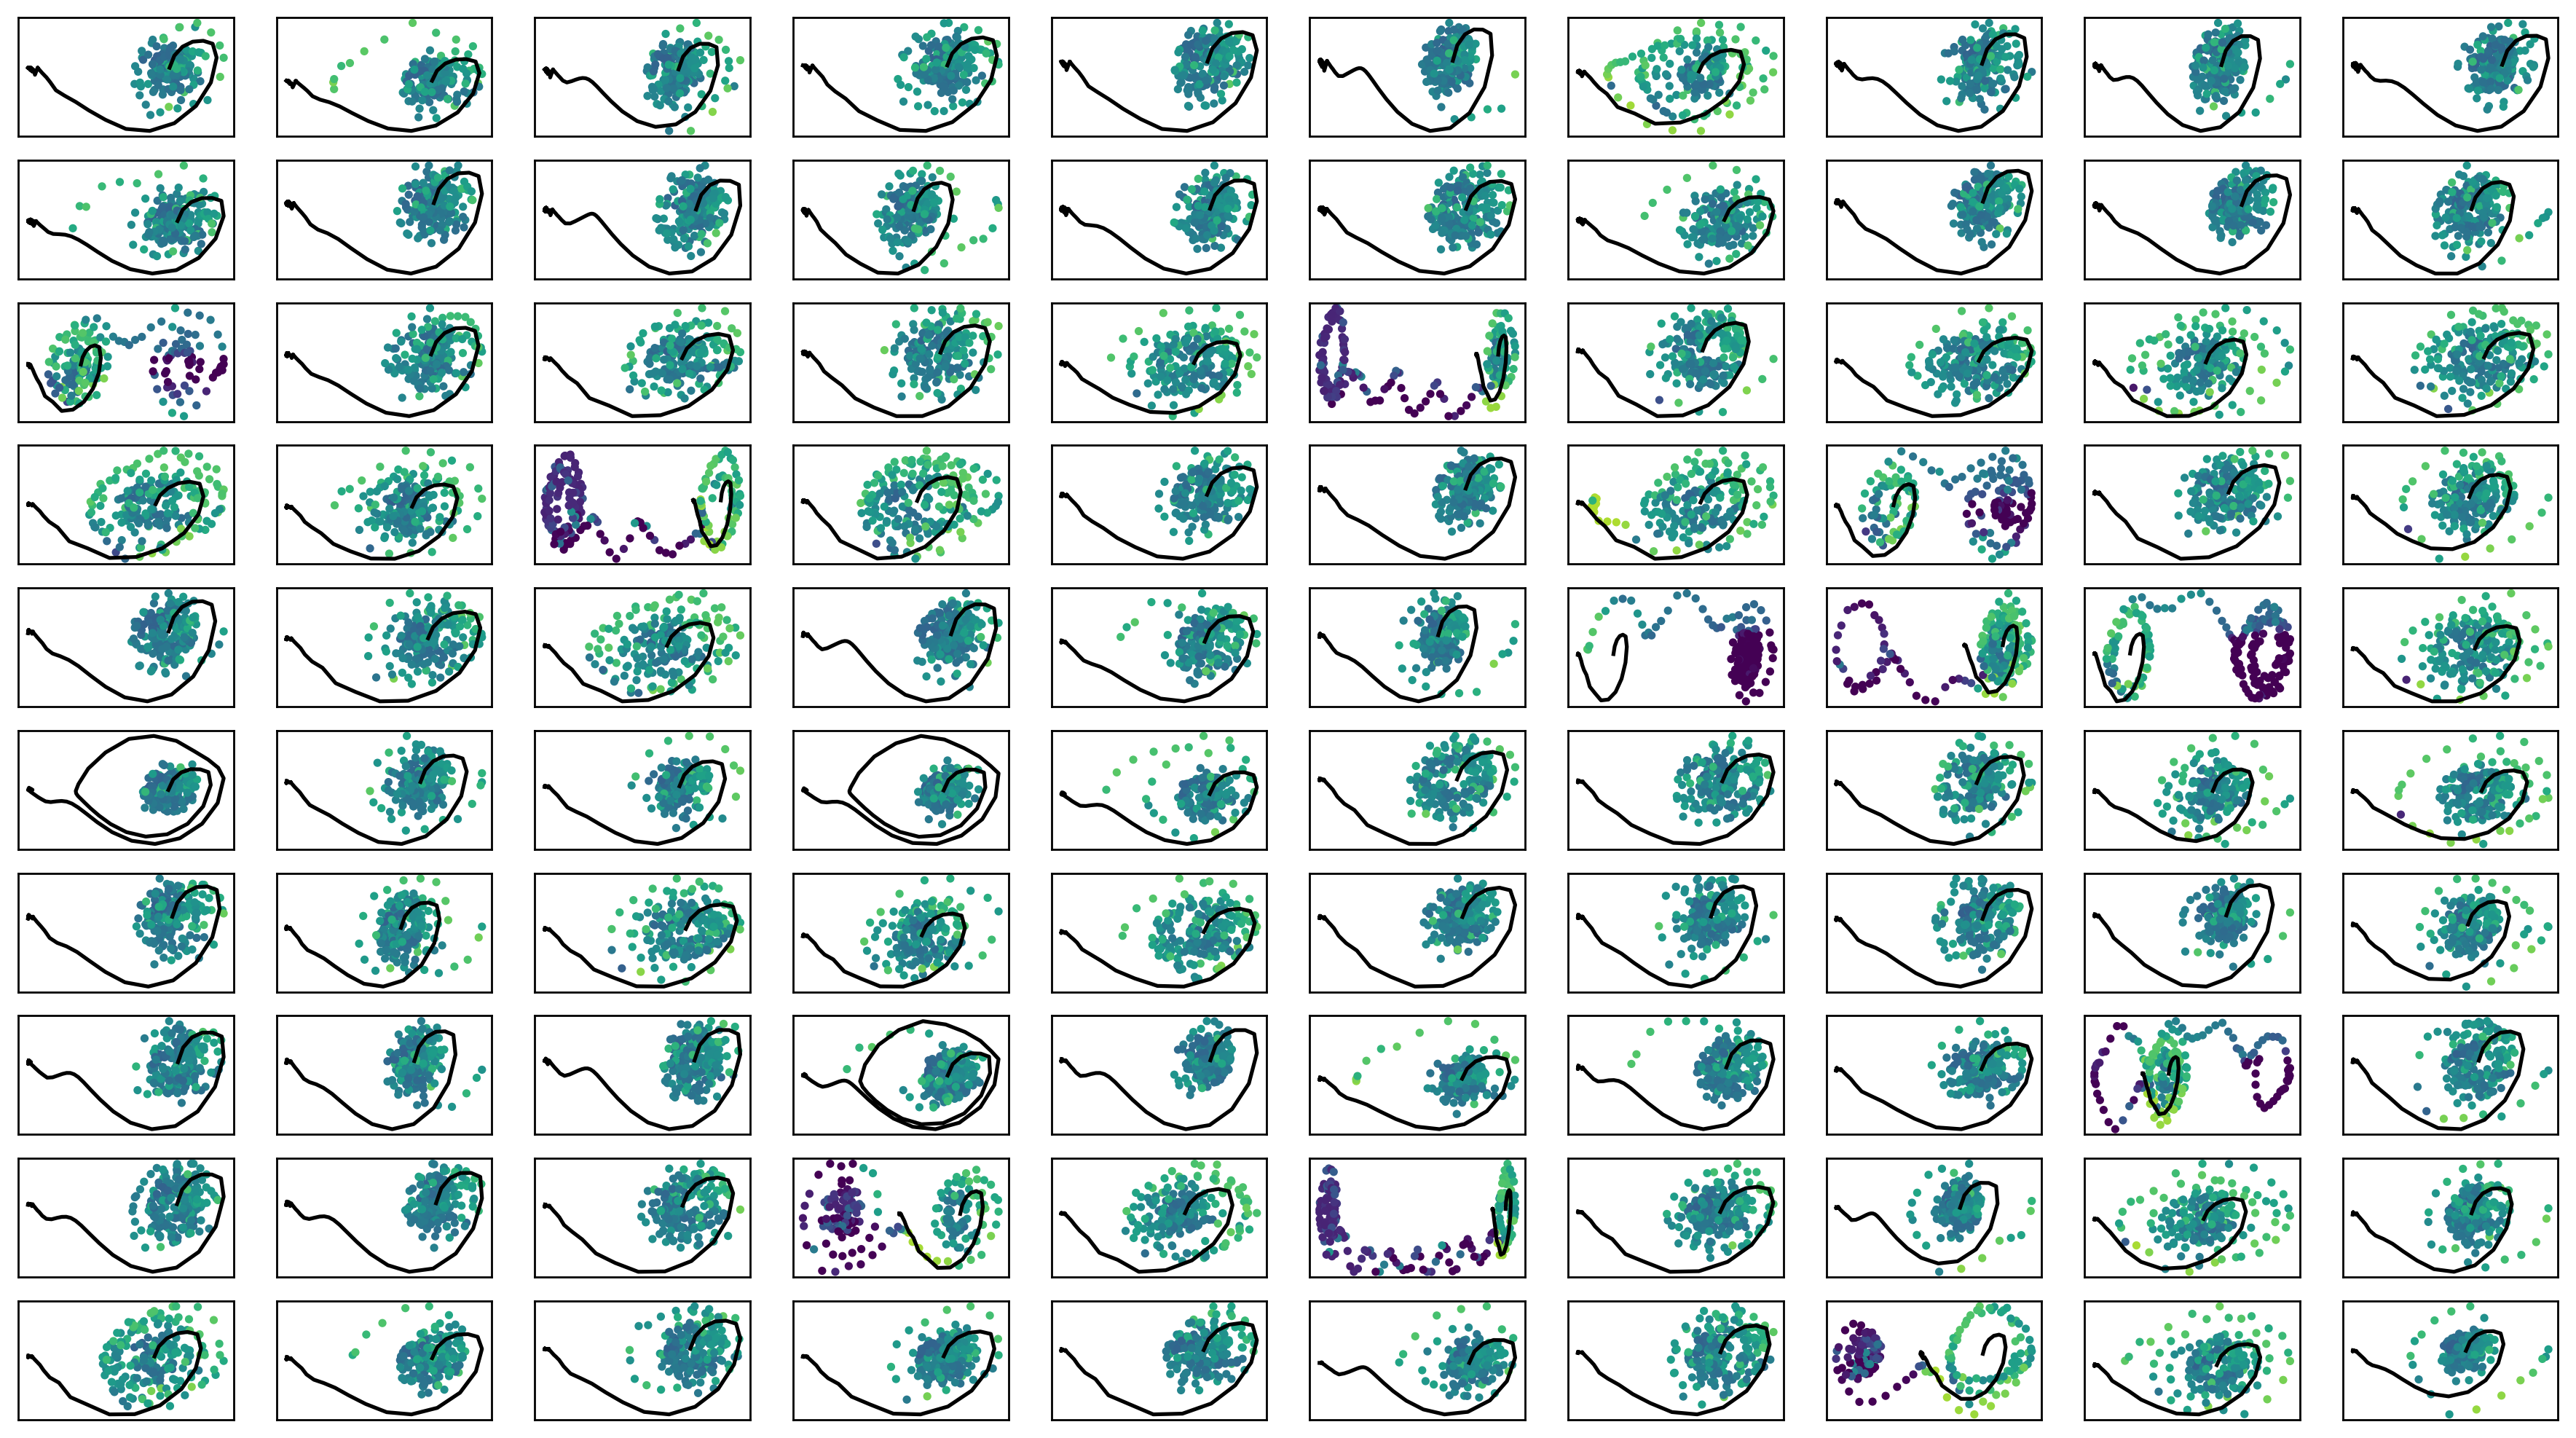

In [14]:

def f(x):
#     return x
    return np.log10(x)

fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter1.png")

In [15]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -425.54512  validloss -494.88313±0.00000  bestvalidloss -494.88313  last_update 0
train: iter 1  trainloss -429.31736  validloss -464.48691±0.00000  bestvalidloss -494.88313  last_update 1
train: iter 2  trainloss -431.94234  validloss -475.11603±0.00000  bestvalidloss -494.88313  last_update 2
train: iter 3  trainloss -432.30648  validloss -452.66938±0.00000  bestvalidloss -494.88313  last_update 3
train: iter 4  trainloss -431.93219  validloss -467.26178±0.00000  bestvalidloss -494.88313  last_update 4
train: iter 5  trainloss -431.65617  validloss -451.08680±0.00000  bestvalidloss -494.88313  last_update 5
train: iter 6  trainloss -432.53340  validloss -465.20258±0.00000  bestvalidloss -494.88313  last_update 6
train: iter 7  trainloss -432.01926  validloss -479.48044±0.00000  bestvalidloss -494.88313  last_update 7
train: iter 8  trainloss -429.48520  validloss -475.57052±0.00000  bestvalidloss -494.88313  last_u

train: iter 76  trainloss -455.41656  validloss -500.81266±0.00000  bestvalidloss -513.70341  last_update 1
train: iter 77  trainloss -442.18650  validloss -516.18440±0.00000  bestvalidloss -516.18440  last_update 0
train: iter 78  trainloss -455.69277  validloss -500.69651±0.00000  bestvalidloss -516.18440  last_update 1
train: iter 79  trainloss -448.54079  validloss -511.75884±0.00000  bestvalidloss -516.18440  last_update 2
train: iter 80  trainloss -453.36469  validloss -488.38088±0.00000  bestvalidloss -516.18440  last_update 3
train: iter 81  trainloss -457.77674  validloss -501.82359±0.00000  bestvalidloss -516.18440  last_update 4
train: iter 82  trainloss -456.03517  validloss -508.31343±0.00000  bestvalidloss -516.18440  last_update 5
train: iter 83  trainloss -454.95238  validloss -501.29345±0.00000  bestvalidloss -516.18440  last_update 6
train: iter 84  trainloss -456.68870  validloss -473.73642±0.00000  bestvalidloss -516.18440  last_update 7
train: iter 85  trainloss -4

train: iter 152  trainloss -468.86954  validloss -491.49806±0.00000  bestvalidloss -550.20944  last_update 19
train: iter 153  trainloss -475.17580  validloss -543.39736±0.00000  bestvalidloss -550.20944  last_update 20
train: iter 154  trainloss -479.60057  validloss -535.07613±0.00000  bestvalidloss -550.20944  last_update 21
train: iter 155  trainloss -478.04396  validloss -544.17973±0.00000  bestvalidloss -550.20944  last_update 22
train: iter 156  trainloss -472.87125  validloss -529.82457±0.00000  bestvalidloss -550.20944  last_update 23
train: iter 157  trainloss -478.14098  validloss -542.70817±0.00000  bestvalidloss -550.20944  last_update 24
train: iter 158  trainloss -474.82899  validloss -539.97712±0.00000  bestvalidloss -550.20944  last_update 25
train: iter 159  trainloss -479.24103  validloss -501.04158±0.00000  bestvalidloss -550.20944  last_update 26
train: iter 160  trainloss -479.91994  validloss -516.65534±0.00000  bestvalidloss -550.20944  last_update 27
train: ite

train: iter 227  trainloss -497.19583  validloss -567.93299±0.00000  bestvalidloss -570.42130  last_update 3
train: iter 228  trainloss -493.33922  validloss -560.44184±0.00000  bestvalidloss -570.42130  last_update 4
train: iter 229  trainloss -492.19742  validloss -569.06792±0.00000  bestvalidloss -570.42130  last_update 5
train: iter 230  trainloss -495.44277  validloss -559.44762±0.00000  bestvalidloss -570.42130  last_update 6
train: iter 231  trainloss -495.83156  validloss -542.08111±0.00000  bestvalidloss -570.42130  last_update 7
train: iter 232  trainloss -495.42603  validloss -539.16789±0.00000  bestvalidloss -570.42130  last_update 8
train: iter 233  trainloss -497.30313  validloss -551.90528±0.00000  bestvalidloss -570.42130  last_update 9
train: iter 234  trainloss -501.63124  validloss -547.98600±0.00000  bestvalidloss -570.42130  last_update 10
train: iter 235  trainloss -496.69571  validloss -581.19807±0.00000  bestvalidloss -581.19807  last_update 0
train: iter 236  t

train: iter 303  trainloss -511.47520  validloss -601.70791±0.00000  bestvalidloss -605.20006  last_update 6
train: iter 304  trainloss -506.95698  validloss -600.92538±0.00000  bestvalidloss -605.20006  last_update 7
train: iter 305  trainloss -514.10453  validloss -596.38309±0.00000  bestvalidloss -605.20006  last_update 8
train: iter 306  trainloss -515.36957  validloss -571.04865±0.00000  bestvalidloss -605.20006  last_update 9
train: iter 307  trainloss -509.97720  validloss -600.02348±0.00000  bestvalidloss -605.20006  last_update 10
train: iter 308  trainloss -515.96139  validloss -598.77729±0.00000  bestvalidloss -605.20006  last_update 11
train: iter 309  trainloss -513.79328  validloss -583.65262±0.00000  bestvalidloss -605.20006  last_update 12
train: iter 310  trainloss -515.44186  validloss -589.88920±0.00000  bestvalidloss -605.20006  last_update 13
train: iter 311  trainloss -515.41020  validloss -584.99851±0.00000  bestvalidloss -605.20006  last_update 14
train: iter 31

train: iter 378  trainloss -531.52679  validloss -599.45331±0.00000  bestvalidloss -628.38406  last_update 10
train: iter 379  trainloss -526.60548  validloss -616.61836±0.00000  bestvalidloss -628.38406  last_update 11
train: iter 380  trainloss -528.36148  validloss -602.43956±0.00000  bestvalidloss -628.38406  last_update 12
train: iter 381  trainloss -529.26121  validloss -606.69954±0.00000  bestvalidloss -628.38406  last_update 13
train: iter 382  trainloss -527.79054  validloss -619.70756±0.00000  bestvalidloss -628.38406  last_update 14
train: iter 383  trainloss -527.42419  validloss -617.52607±0.00000  bestvalidloss -628.38406  last_update 15
train: iter 384  trainloss -530.77538  validloss -612.25232±0.00000  bestvalidloss -628.38406  last_update 16
train: iter 385  trainloss -528.96831  validloss -605.97942±0.00000  bestvalidloss -628.38406  last_update 17
train: iter 386  trainloss -527.32363  validloss -610.93791±0.00000  bestvalidloss -628.38406  last_update 18
train: ite

train: iter 453  trainloss -545.86015  validloss -640.67379±0.00000  bestvalidloss -649.30495  last_update 7
train: iter 454  trainloss -541.12832  validloss -613.49767±0.00000  bestvalidloss -649.30495  last_update 8
train: iter 455  trainloss -545.50436  validloss -639.06261±0.00000  bestvalidloss -649.30495  last_update 9
train: iter 456  trainloss -540.00510  validloss -619.61190±0.00000  bestvalidloss -649.30495  last_update 10
train: iter 457  trainloss -543.11767  validloss -631.58076±0.00000  bestvalidloss -649.30495  last_update 11
train: iter 458  trainloss -543.21014  validloss -620.61347±0.00000  bestvalidloss -649.30495  last_update 12
train: iter 459  trainloss -542.09182  validloss -655.32724±0.00000  bestvalidloss -655.32724  last_update 0
train: iter 460  trainloss -540.42348  validloss -644.90025±0.00000  bestvalidloss -655.32724  last_update 1
train: iter 461  trainloss -543.63233  validloss -636.99767±0.00000  bestvalidloss -655.32724  last_update 2
train: iter 462 

train: iter 528  trainloss -556.84263  validloss -656.41331±0.00000  bestvalidloss -673.77743  last_update 2
train: iter 529  trainloss -559.12001  validloss -651.50718±0.00000  bestvalidloss -673.77743  last_update 3
train: iter 530  trainloss -558.48528  validloss -663.42814±0.00000  bestvalidloss -673.77743  last_update 4
train: iter 531  trainloss -561.80852  validloss -670.49139±0.00000  bestvalidloss -673.77743  last_update 5
train: iter 532  trainloss -551.65600  validloss -653.20693±0.00000  bestvalidloss -673.77743  last_update 6
train: iter 533  trainloss -554.54490  validloss -650.21364±0.00000  bestvalidloss -673.77743  last_update 7
train: iter 534  trainloss -558.03216  validloss -670.55798±0.00000  bestvalidloss -673.77743  last_update 8
train: iter 535  trainloss -556.74289  validloss -672.57675±0.00000  bestvalidloss -673.77743  last_update 9
train: iter 536  trainloss -561.33727  validloss -666.97089±0.00000  bestvalidloss -673.77743  last_update 10
train: iter 537  t

train: iter 603  trainloss -597.80140  validloss -706.74601±0.00000  bestvalidloss -714.70229  last_update 4
train: iter 604  trainloss -595.19279  validloss -687.93234±0.00000  bestvalidloss -714.70229  last_update 5
train: iter 605  trainloss -588.35928  validloss -651.81425±0.00000  bestvalidloss -714.70229  last_update 6
train: iter 606  trainloss -594.42168  validloss -703.41921±0.00000  bestvalidloss -714.70229  last_update 7
train: iter 607  trainloss -585.39101  validloss -668.48584±0.00000  bestvalidloss -714.70229  last_update 8
train: iter 608  trainloss -590.20299  validloss -682.05598±0.00000  bestvalidloss -714.70229  last_update 9
train: iter 609  trainloss -590.85004  validloss -666.58938±0.00000  bestvalidloss -714.70229  last_update 10
train: iter 610  trainloss -596.16895  validloss -704.17662±0.00000  bestvalidloss -714.70229  last_update 11
train: iter 611  trainloss -590.54200  validloss -714.92259±0.00000  bestvalidloss -714.92259  last_update 0
train: iter 612  

train: iter 678  trainloss -610.20084  validloss -703.65210±0.00000  bestvalidloss -746.26300  last_update 9
train: iter 679  trainloss -599.43434  validloss -717.06955±0.00000  bestvalidloss -746.26300  last_update 10
train: iter 680  trainloss -614.96043  validloss -726.17536±0.00000  bestvalidloss -746.26300  last_update 11
train: iter 681  trainloss -614.57069  validloss -746.01751±0.00000  bestvalidloss -746.26300  last_update 12
train: iter 682  trainloss -609.71530  validloss -733.26547±0.00000  bestvalidloss -746.26300  last_update 13
train: iter 683  trainloss -618.76341  validloss -714.94435±0.00000  bestvalidloss -746.26300  last_update 14
train: iter 684  trainloss -620.25909  validloss -706.34890±0.00000  bestvalidloss -746.26300  last_update 15
train: iter 685  trainloss -615.70009  validloss -704.76500±0.00000  bestvalidloss -746.26300  last_update 16
train: iter 686  trainloss -624.26342  validloss -723.59949±0.00000  bestvalidloss -746.26300  last_update 17
train: iter

train: iter 754  trainloss -641.60771  validloss -741.90837±0.00000  bestvalidloss -765.01273  last_update 11
train: iter 755  trainloss -610.63320  validloss -756.84756±0.00000  bestvalidloss -765.01273  last_update 12
train: iter 756  trainloss -638.00389  validloss -724.81804±0.00000  bestvalidloss -765.01273  last_update 13
train: iter 757  trainloss -621.31193  validloss -750.79116±0.00000  bestvalidloss -765.01273  last_update 14
train: iter 758  trainloss -637.23300  validloss -727.29233±0.00000  bestvalidloss -765.01273  last_update 15
train: iter 759  trainloss -632.07885  validloss -722.63172±0.00000  bestvalidloss -765.01273  last_update 16
train: iter 760  trainloss -618.49205  validloss -753.81222±0.00000  bestvalidloss -765.01273  last_update 17
train: iter 761  trainloss -643.26051  validloss -764.00534±0.00000  bestvalidloss -765.01273  last_update 18
train: iter 762  trainloss -631.50462  validloss -732.33117±0.00000  bestvalidloss -765.01273  last_update 19
train: ite

train: iter 829  trainloss -653.64781  validloss -731.67423±0.00000  bestvalidloss -773.96674  last_update 36
train: iter 830  trainloss -637.41550  validloss -748.55542±0.00000  bestvalidloss -773.96674  last_update 37
train: iter 831  trainloss -636.90445  validloss -748.27074±0.00000  bestvalidloss -773.96674  last_update 38
train: iter 832  trainloss -650.45221  validloss -761.57280±0.00000  bestvalidloss -773.96674  last_update 39
train: iter 833  trainloss -645.09769  validloss -762.53560±0.00000  bestvalidloss -773.96674  last_update 40
train: iter 834  trainloss -652.13466  validloss -745.52942±0.00000  bestvalidloss -773.96674  last_update 41
train: iter 835  trainloss -651.52637  validloss -756.51245±0.00000  bestvalidloss -773.96674  last_update 42
train: iter 836  trainloss -652.76357  validloss -763.74895±0.00000  bestvalidloss -773.96674  last_update 43
train: iter 837  trainloss -642.92449  validloss -759.28730±0.00000  bestvalidloss -773.96674  last_update 44
train: ite

train: iter 904  trainloss -637.21515  validloss -731.56379±0.00000  bestvalidloss -783.61841  last_update 35
train: iter 905  trainloss -651.69163  validloss -759.96181±0.00000  bestvalidloss -783.61841  last_update 36
train: iter 906  trainloss -654.81155  validloss -771.04869±0.00000  bestvalidloss -783.61841  last_update 37
train: iter 907  trainloss -657.94954  validloss -734.71771±0.00000  bestvalidloss -783.61841  last_update 38
train: iter 908  trainloss -658.14268  validloss -770.56270±0.00000  bestvalidloss -783.61841  last_update 39
train: iter 909  trainloss -655.60187  validloss -743.19167±0.00000  bestvalidloss -783.61841  last_update 40
train: iter 910  trainloss -667.43162  validloss -782.71104±0.00000  bestvalidloss -783.61841  last_update 41
train: iter 911  trainloss -664.58965  validloss -741.64997±0.00000  bestvalidloss -783.61841  last_update 42
train: iter 912  trainloss -664.54831  validloss -763.40774±0.00000  bestvalidloss -783.61841  last_update 43
train: ite

train: iter 979  trainloss -666.49115  validloss -753.91130±0.00000  bestvalidloss -784.53752  last_update 63
train: iter 980  trainloss -663.74758  validloss -769.77620±0.00000  bestvalidloss -784.53752  last_update 64
train: iter 981  trainloss -667.70923  validloss -757.50378±0.00000  bestvalidloss -784.53752  last_update 65
train: iter 982  trainloss -673.78274  validloss -764.80287±0.00000  bestvalidloss -784.53752  last_update 66
train: iter 983  trainloss -665.21730  validloss -771.25686±0.00000  bestvalidloss -784.53752  last_update 67
train: iter 984  trainloss -668.50368  validloss -759.68089±0.00000  bestvalidloss -784.53752  last_update 68
train: iter 985  trainloss -671.59520  validloss -773.27997±0.00000  bestvalidloss -784.53752  last_update 69
train: iter 986  trainloss -664.24050  validloss -748.71699±0.00000  bestvalidloss -784.53752  last_update 70
train: iter 987  trainloss -658.62834  validloss -684.74906±0.00000  bestvalidloss -784.53752  last_update 71
train: ite

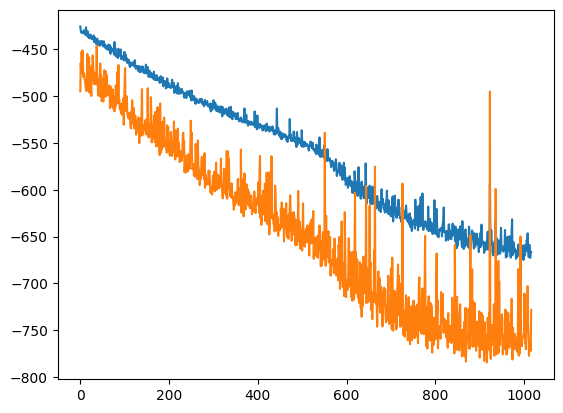

alpha 0.1 default_lr 0.0005


In [16]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [17]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_data_fixlen()
# simdata0d = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_data_fixlen()
# simdata0e = copy.deepcopy(iwvi.simenv_rolloutdata)



実環境方策rollout vs Sim環境方策rollout


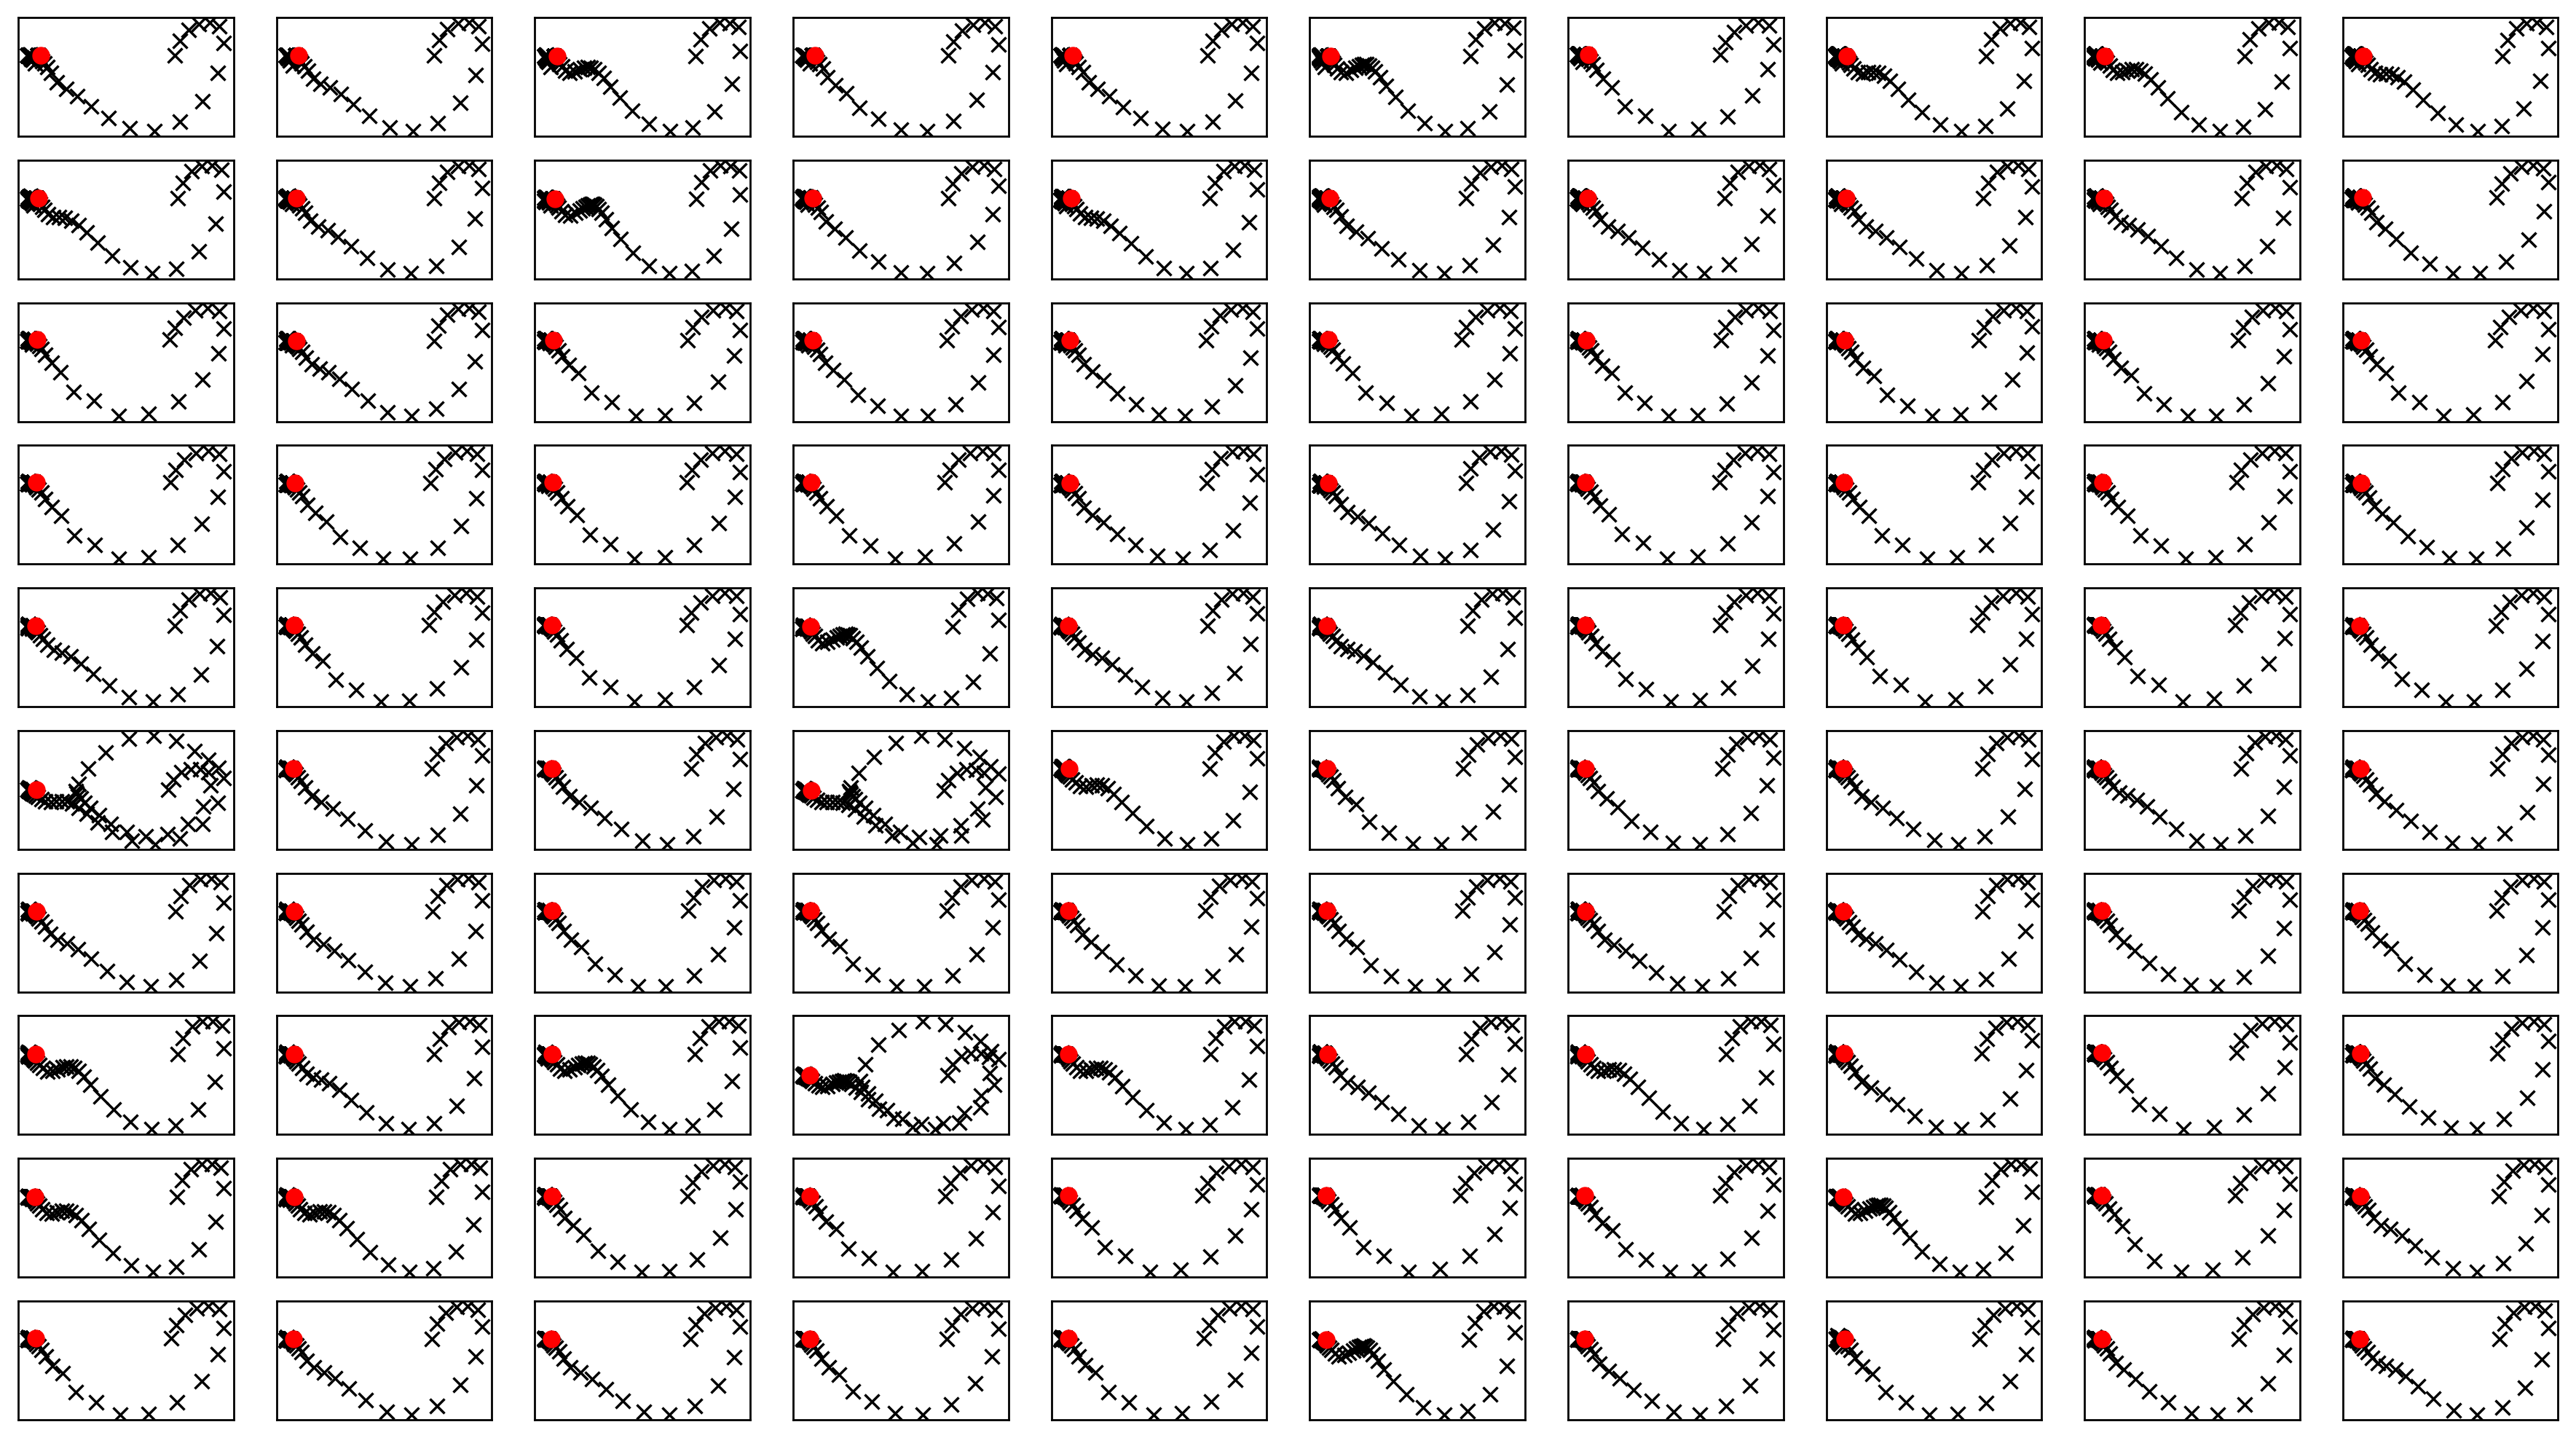

In [18]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
#     ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
#     ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 
#     ax_list[-1].plot(simdata0d[i][:,0], simdata0d[i][:,1]) 
#     ax_list[-1].plot(simdata0e[i][:,0], simdata0e[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")     
plt.savefig(figfilenamehead+"iter1.png")
plt.savefig(figfilenamehead+"iter1.eps")
# plt.savefig(figfilenamehead+"iter1.pdf")
print("実環境方策rollout vs Sim環境方策rollout")

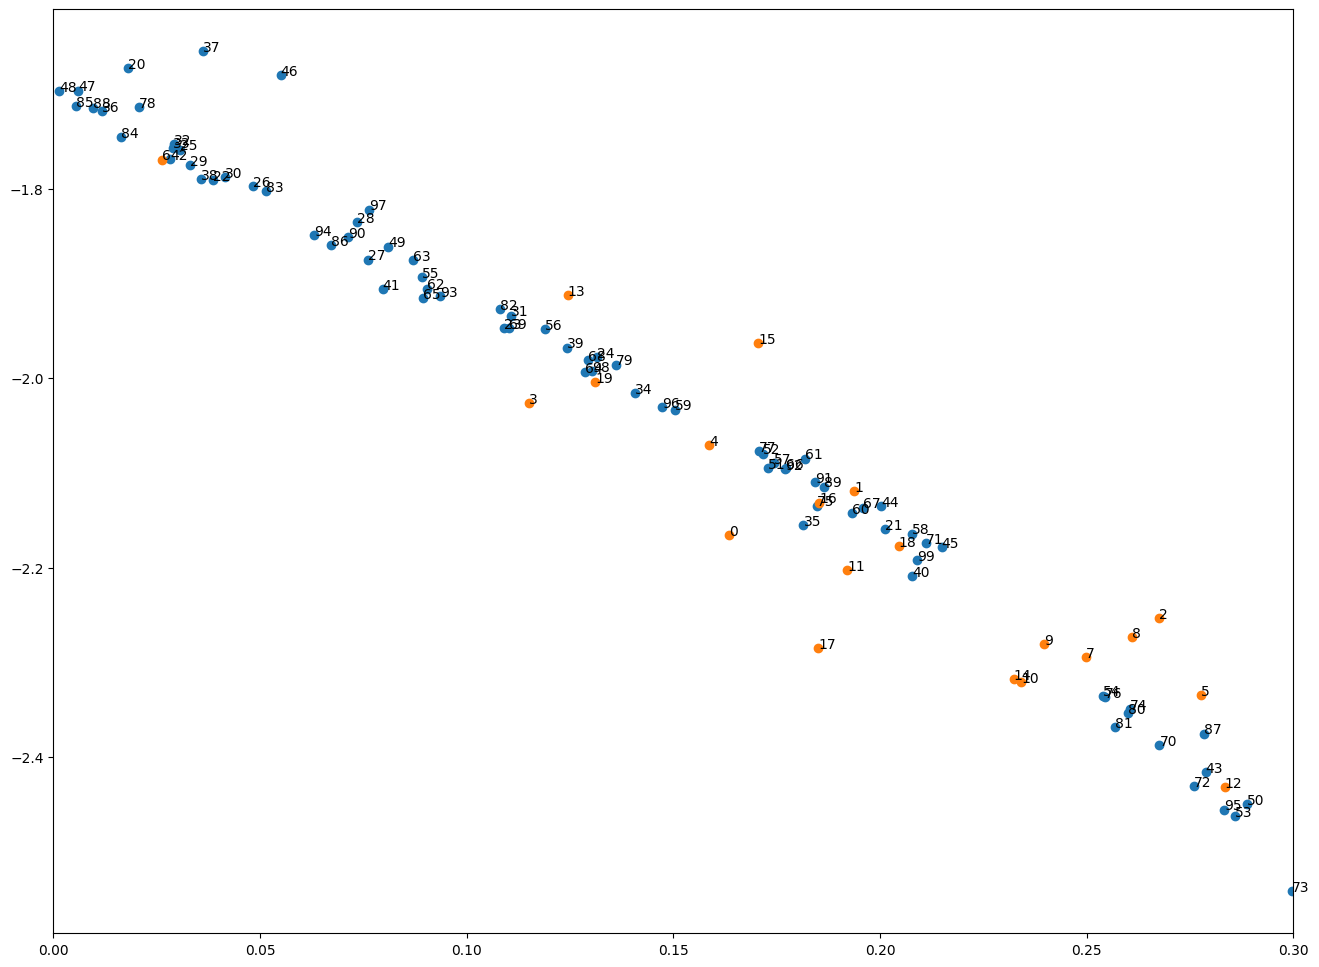

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [19]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter1.png")
plt.savefig(figfilenamehead+"damping_latent_iter1.eps")
# plt.savefig(figfilenamehead+"damping_latent_iter1.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])
# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [20]:
print(datetime.datetime.now())

2023-06-06 11:30:37.081978


# Iter2

In [21]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28


KeyboardInterrupt: 

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter2.png")

In [ ]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()

train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()

In [ ]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [ ]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
#     ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
#     ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")     
plt.savefig(figfilenamehead+"joint_iter2.png")
plt.savefig(figfilenamehead+"joint_iter2.eps")
# plt.savefig(figfilenamehead+"joint_iter2.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter2.png")
plt.savefig(figfilenamehead+"damping_latent_iter2.eps")
# plt.savefig(figfilenamehead+"damping_latent_iter2.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

In [ ]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


In [ ]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter3.png")

In [ ]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

In [ ]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [ ]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
#     ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
#     ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro") 
plt.savefig(figfilenamehead+"joint_iter3.png")
plt.savefig(figfilenamehead+"joint_iter3.eps")
# plt.savefig(figfilenamehead+"joint_iter3.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter3.png")
plt.savefig(figfilenamehead+"damping_latent_iter3.eps")
# plt.savefig(figfilenamehead+"damping_latent_iter3.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

# 評価関数計算

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter6.png")

In [ ]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


In [ ]:
print(iwvi.initial_belief)


In [ ]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

In [ ]:
iwvi.save(ckpt_key="policy_optimization_iter1")

In [ ]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

In [ ]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")